In [1]:
# Environment setup
import pandas as pd
import numpy as n
import json
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from datetime import date, datetime

import sys
sys.path.append('/Users/kleomeniskogias/Visual Studio codee/Mycodes')

from src.helpful_functions import read_json_as_dict
from src.one_hot_encoding import encode_categorical_variable, join_to_df
from src.classification_class import CustomClassifier

import pycountry_convert as pc
import matplotlib.pyplot as plt
import math
import scipy.stats as st

/Users/kleomeniskogias/opt/anaconda3/envs/dataiku_kernel/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Functions

In [2]:
def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name


# Universe breakdown
def universe_breakdown(age, full_or_part_time_employment_stat, major_occupation_code):
    if major_occupation_code == 'Armed Forces':
        return 'Armed Forces'
    elif age < 18:
        return 'Underaged'
    else:
        return 'Civilians'

    
# Employment status (unemployed, hourly paid, children)
def create_manual_employment_status(unemployment_flag, universe_description, own_business_or_self_employed, hourly_wage, enroll_in_edu_inst_last_wk, veterans_benefits, full_or_part_time_employment_stat):
    if (unemployment_flag == 1) | (full_or_part_time_employment_stat in [ 'Unemployed part- time', 'Unemployed full-time']):
        return 'Unemployed'
    elif universe_description == 'Underaged':
        return 'Underaged'
    elif enroll_in_edu_inst_last_wk != 'Not in universe' :
        return '(Uni) student'
    elif own_business_or_self_employed == 1:
        return 'Own business - self employed'
    elif universe_description == 'Armed Forces':
        return 'Armed Forces'
    elif hourly_wage > 0:
        return 'Hourly wage employee'
    elif veterans_benefits == 1:
        return 'Veteran'
    elif full_or_part_time_employment_stat == 'Not in labor force':
        return 'Not in Label Force'
    elif full_or_part_time_employment_stat == 'Full-time schedules':
        return 'Full-time'
    elif full_or_part_time_employment_stat in [ 'PT for econ reasons usually FT', 'PT for econ reasons usually PT', 'PT for non-econ reasons usually FT']:
        return 'Part-time'
    else:
        return 'Remaining'

def plot_bar_with_percentages(input_df, categorical_column, sizing_column,percentage_column, color_list, plot_tilte):
    plt.figure(figsize=(8, 8))
    graph = plt.barh(input_df[categorical_column], input_df[sizing_column], color=color_list)  # ['b', 'g', 'r', 'c', 'm', 'y', 'r', 'forestgreen']
    plt.title(plot_tilte)
    
    i = 0
    for p in graph:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        
        plt.text(x+width/2,
                y+height*1.01,
                str(employment_status_table[percentage_column][i])+'%',
                ha='center',
                weight='bold')
        i += 1
    plt.show()

# Save model performance
def save_dataframe_to_csv(dataframe, filename):
    dataframe.to_csv(filename)

def get_date_timestamp():
    ts = datetime.now()
    return ts.strftime("%d/%m/%Y, %H:%M")

def save_model_performance_in_dataframe(version, classifiers_list, running_date = get_date_timestamp(), save_flag = 1): # classifiers_list = [rf, lr, xgb]
    # Create a dataframe with the resutls
    column_names = []
    for classifier in classifiers_list:
        column_names.append(classifier.model) # ["RF", "LR", "XGBoost"]
    # Populate dataframe
    classifiers_outputs_temp = pd.DataFrame(columns = column_names, index = ["Accuracy" , "Precision", "F1_score unweighted", "F1_score weighted", "Training Accuracy", "Version", "Date"])
    for classifier in classifiers_list:
        classifiers_outputs_temp.loc['Training Accuracy', classifier.model] = round(classifier.training_accuracy, 3)
        classifiers_outputs_temp.loc['Accuracy', classifier.model] = round(classifier.accuracy, 3)
        classifiers_outputs_temp.loc['Precision', classifier.model] = round(classifier.precision, 3)
        classifiers_outputs_temp.loc['F1_score unweighted', classifier.model] = round(classifier.f1_score_macro, 3)
        classifiers_outputs_temp.loc['F1_score weighted', classifier.model] = round(classifier.f1_score_weighted, 3)
        classifiers_outputs_temp.loc['Version', classifier.model] = version
        classifiers_outputs_temp.loc['Date', classifier.model] = running_date
    classifiers_outputs_temp = classifiers_outputs_temp.T
    classifiers_outputs_temp = classifiers_outputs_temp.reset_index().rename(columns = {'index' : 'Model'}).set_index('Date')
    # print(classifiers_outputs_temp)
    # If there is a csv file get the CSV
    try:
        classifiers_outputs = pd.read_csv("data/Processing/model_performance.csv").set_index('Date')
    except:
        print("The classifier_outputs csv does not exist")
        print("Creating the classifiers output pandas dataframe...")
        classifiers_outputs = classifiers_outputs_temp
    else:
        classifiers_outputs = classifiers_outputs.append(classifiers_outputs_temp)


    if save_flag:
        save_dataframe_to_csv(classifiers_outputs, "./data/Processing/model_performance.csv")

    return classifiers_outputs_temp

## Universe
The universe is US residents living in housing units and members of the Armed Forces living in civilian housing units on a military base or in a household not on a military base.

TODO
1. Correlation between input variables
2. Cleaning of data
3. oversampling
4. How can I identify who is in the armed forces? (full or part time employment stat)
5. countries mappings
6. Group together similar variables
7. Identify non-universe 1 year ago
8. Oversampling


In [3]:
# Configurations
columns_type = read_json_as_dict("config/features_type.json")

In [5]:
# Read training data
training_data = pd.read_csv("data/Input/census_income_learn.csv", index_col=False, header=None)
print(training_data.shape)

# Delete the weighting column
training_data  = training_data.drop(training_data.iloc[:,24:25], axis = 1)
training_data.shape

# Read test dataset
test_data = pd.read_csv("data/Input/census_income_test.csv", index_col=False, header=None)
test_data = test_data.drop(test_data.iloc[:,24:25], axis = 1)
print(test_data.shape)

(199523, 42)
(99762, 41)


# Data Cleaning

In [6]:
# Drop duplicates - There is no user id in order to know whether it is the same user or not
training_data.drop_duplicates(inplace=True)
test_data.drop_duplicates(inplace=True)

print(training_data.shape, test_data.shape)


(152896, 41) (78864, 41)


In [7]:
# Add a user_id column to the data
training_data['user_id'] = list(range(0, training_data.shape[0] ))
training_data = training_data.set_index('user_id')

test_data['user_id'] = list(range(training_data.shape[0], test_data.shape[0] + training_data.shape[0] ))
test_data = test_data.set_index('user_id')

In [8]:
# Create full dataset
X_data = training_data.loc[:, 0:40]
X_data.columns = list(columns_type.keys())
X_data

y = training_data.loc[:, 41]
print(X_data.shape, y.shape)

y.name = 'Label'
full_dataset = X_data.join(y)

(152896, 40) (152896,)


In [9]:
# Strip values of categorical columns
continuous_variables = []
encoded_variables = []
for key, value in columns_type.items():
    if value == 'continuous':
        continuous_variables.append(key)
    else:
        encoded_variables.append(key)


for col in encoded_variables:
    if col in ['detailed industry recode', 'detailed occupation recode', 'own business or self employed', 'veterans benefits', 'year']:
        full_dataset[col] = full_dataset[col].astype(str)
    full_dataset[col] = full_dataset[col].apply(lambda x : x.strip())

## Mappings

In [10]:
## Mappings
# industry_codes_dict = read_json_as_dict("config/detailed_industry_code.json")
# industry_codes_dict = {int(k) : v for k,v in industry_codes_dict.items()} # Code 52 seems that is not used
# own_business_code = {0 : 'niu', 1 : 'yes', 2 : 'no'}

In [11]:
country_columns = ['country of birth father', 'country of birth mother', 'country of birth self']

In [12]:
# Build countries continents dictionary
misspelled_countries = {'Columbia' : 'Colombia', 'Trinadad and Tobago' : 'Trinidad and Tobago', 'Holand Netherlands' : 'Netherlands' }

countries_continents_dict = {}
for column in country_columns:
    for init_country in list(full_dataset[column].drop_duplicates()):
        # countries correction
        country = init_country
        country = country.strip()
        country = country.replace('-', ' ')
        country = country.replace('&', ' and ')
        try:
            country = misspelled_countries[country]
        except:
            country
        # UK
        if country in ['Scotland', 'England', 'Wales', 'Ireland']:
            country = 'United Kingdom'
        if country in ['United-States']:
            countries_continents_dict[country] = 'North America'
        elif country == '?':
            countries_continents_dict[init_country] = init_country
        else:
            try:
                countries_continents_dict[init_country] = country_to_continent(country)
            except:
                if country == 'Yugoslavia':
                    countries_continents_dict[init_country] = 'Europe'
                if country == 'Outlying U S (Guam USVI etc)':
                    countries_continents_dict[init_country] = 'North America'

In [13]:
# Map countries to continents
for col in country_columns:
    new_col_name = col.replace('country', 'continent')
    full_dataset[new_col_name] = full_dataset[col].apply(lambda x : countries_continents_dict[x])

full_dataset[['continent of birth father', 'continent of birth mother', 'continent of birth self']]

,continent of birth father,continent of birth mother,continent of birth self
user_id,,,
0,North America,North America,North America
1,North America,North America,North America
2,Asia,Asia,Asia
3,North America,North America,North America
4,North America,North America,North America
...,...,...,...
152891,North America,North America,North America
152892,North America,North America,North America
152893,North America,North America,North America


# Create new columns

In [14]:
# Create new columns
capital_fields = full_dataset[['capital gains', 'capital losses', 'dividends from stocks']].join(y)
full_dataset['alternative_income_sources'] = full_dataset['capital gains'] + full_dataset['dividends from stocks'] - full_dataset['capital losses']
full_dataset['unemployment_flag'] = full_dataset['reason for unemployment'].apply(lambda x : 0 if x == 'Not in universe' else 1)
full_dataset['universe_descritpion'] = full_dataset.apply(lambda row : universe_breakdown(row['age'], row['full or part time employment stat'], row['major occupation code']), axis = 1)
# full_dataset['employment_status_manual']

In [15]:
full_dataset['universe_descritpion'].value_counts()

Civilians       134383
Underaged        18477
Armed Forces        36
Name: universe_descritpion, dtype: int64

# Data Visualisation

<AxesSubplot: ylabel='Frequency'>

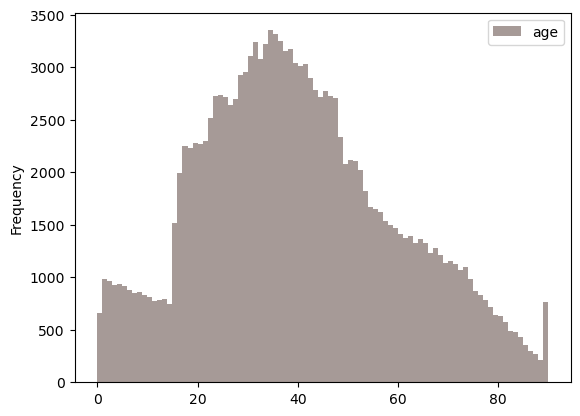

In [16]:
full_dataset[['age']].plot.hist(bins = full_dataset.age.max(), color = '#a69a97')

<AxesSubplot: title={'center': 'Gender Distributions'}, ylabel='age'>

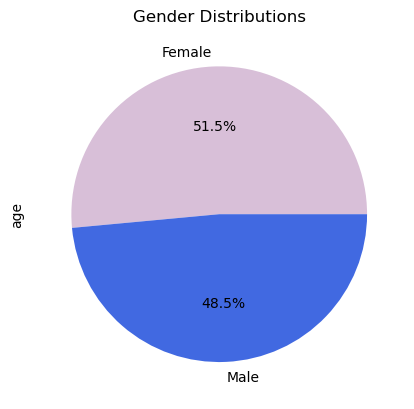

In [17]:
full_dataset.groupby(['sex'])['age'].count().plot.pie(autopct='%1.1f%%', title = "Gender Distributions", colors = ['thistle', 'royalblue'])

<AxesSubplot: ylabel='education_categorical'>

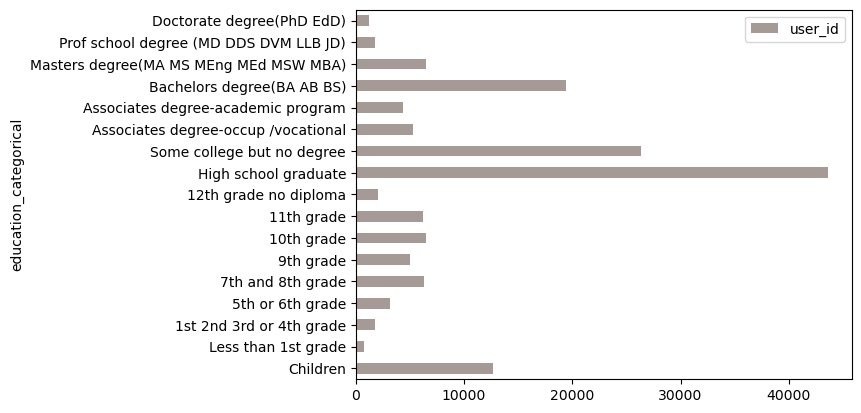

In [18]:
# Education bar chart

education_list = [
    "Children", "Less than 1st grade", "1st 2nd 3rd or 4th grade", "5th or 6th grade", "7th and 8th grade", "9th grade", "10th grade", "11th grade", "12th grade no diploma", 
    "High school graduate", "Some college but no degree", "Associates degree-occup /vocational", "Associates degree-academic program", "Bachelors degree(BA AB BS)", "Masters degree(MA MS MEng MEd MSW MBA)",
    "Prof school degree (MD DDS DVM LLB JD)", "Doctorate degree(PhD EdD)"
]       

full_dataset['education_categorical'] = pd.Categorical(full_dataset['education'], education_list)
full_dataset.reset_index().groupby(['education_categorical'])['user_id'].count().reset_index().sort_values('education_categorical').set_index('education_categorical').plot.barh(color = '#a69a97')

<AxesSubplot: title={'center': 'Universe Description'}, ylabel='user_id'>

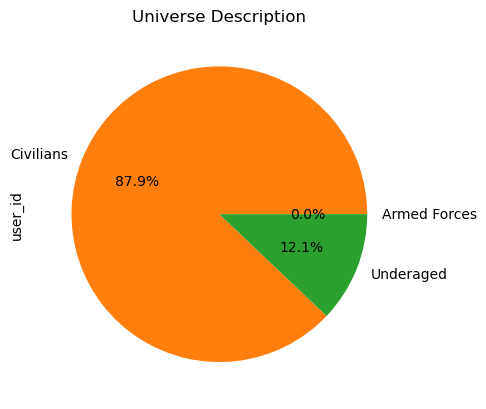

In [19]:
# Universe description
full_dataset.reset_index().groupby(['universe_descritpion'])['user_id'].count().plot.pie(autopct='%1.1f%%', title = "Universe Description")

Remaining               56393
Full-time               33461
Not in Label Force      18036
Underaged               17991
Hourly wage employee    10065
Unemployed               6360
(Uni) student            6357
Part-time                4232
Armed Forces                1
Name: employment_status_manual, dtype: int64


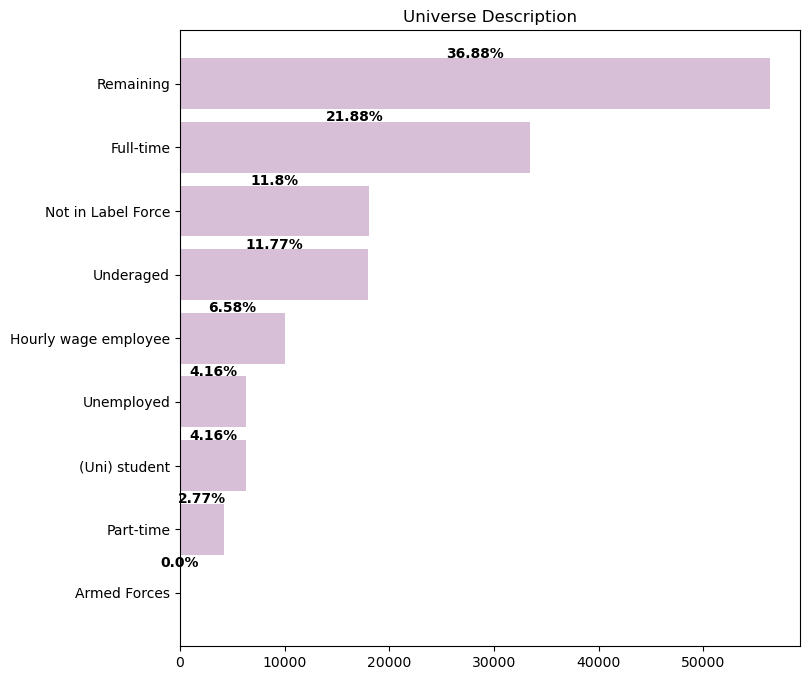

In [20]:
full_dataset['employment_status_manual'] = (full_dataset.apply(lambda row : create_manual_employment_status(
    row['unemployment_flag'], row['universe_descritpion'], row['own business or self employed'], row['wage per hour'], row['enroll in edu inst last wk'], row['veterans benefits'], row['full or part time employment stat']), axis = 1))
print(full_dataset['employment_status_manual'].value_counts())
employment_status_table = full_dataset.reset_index().groupby(['employment_status_manual'])['user_id'].count()

employment_status_table.name = 'Counting'
employment_status_table = employment_status_table.reset_index()

percentage = [] 
for i in range(employment_status_table.shape[0]):
    pct = (employment_status_table.Counting[i] / employment_status_table.Counting.sum()) * 100
    percentage.append(round(pct, 2))


# Horizontal Bar with percentages

# Estimate percentages
employment_status_table['Percentage'] =  percentage
employment_status_table = employment_status_table.sort_values('Percentage').reset_index()


color_list = ['forestgreen', 'limegreen', 'darkgreen', 'green', 'lime', 'seagreen', 'mediumseagreen', 'springgreen', 'aquamarine']
color_list = ['thistle']
plot_bar_with_percentages(employment_status_table, 'employment_status_manual', 'Counting', 'Percentage', color_list, 'Universe Description')


In [21]:
# Data Issue
full_dataset[full_dataset['employment_status_manual'] == 'Remaining']['full or part time employment stat'].value_counts()

Children or Armed Forces    56393
Name: full or part time employment stat, dtype: int64

<AxesSubplot: ylabel='Frequency'>

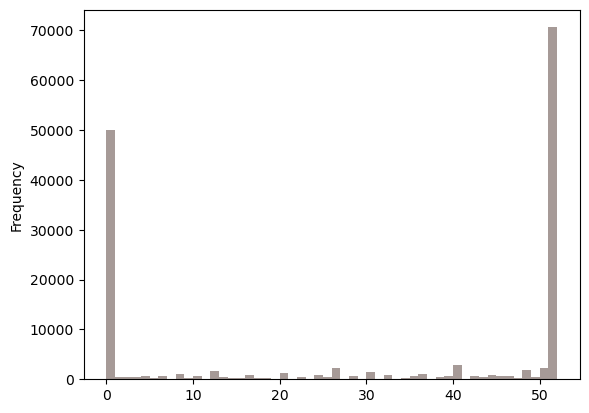

In [22]:
full_dataset['weeks worked in year'].plot.hist(bins = 52, color = '#a69a97')

citizenship
Native- Born in the United States              130946
Foreign born- Not a citizen of U S              12887
Foreign born- U S citizen by naturalization      5829
Native- Born abroad of American Parent(s)        1727
Native- Born in Puerto Rico or U S Outlying      1507
Name: user_id, dtype: int64


<AxesSubplot: title={'center': 'Citizenship'}, ylabel=' '>

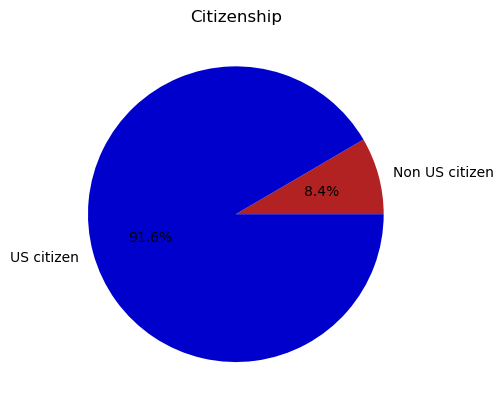

In [23]:
# Citizenship
def estimate_citizenship(citizenship):
    if citizenship in ['Foreign born- Not a citizen of U S']:
        return 'Non US citizen'
    else:
        return 'US citizen'


print(full_dataset.reset_index().groupby(['citizenship'])['user_id'].count().sort_values(ascending = False))
full_dataset['citizenship_flag'] = full_dataset['citizenship'].apply(lambda x : estimate_citizenship(x))
citizenship_table = full_dataset.reset_index().groupby(['citizenship_flag'])['user_id'].count()
citizenship_table.name = ' '
citizenship_table.plot.pie(autopct='%1.1f%%', title = "Citizenship", colors = ['firebrick', 'mediumblue'])


<AxesSubplot: title={'center': 'Alternative Income Sources'}, ylabel='Frequency'>

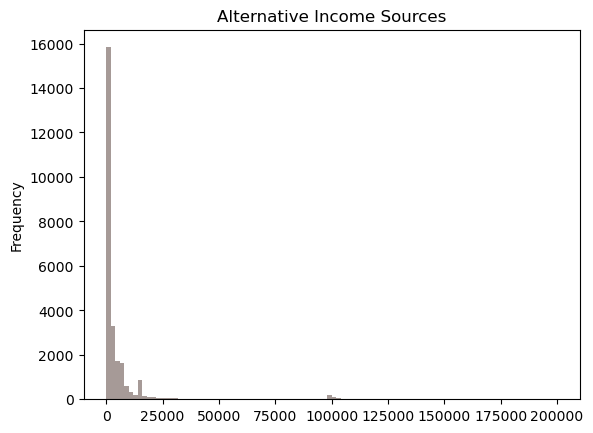

In [24]:
full_dataset[full_dataset['alternative_income_sources'] > 0]['alternative_income_sources'].plot.hist(bins = 100, color = '#a69a97', title = 'Alternative Income Sources')

In [25]:
full_dataset.reset_index().groupby(['detailed industry recode', 'major industry code'])['user_id'].count().to_csv("data/Processing/major_industry_codes.csv")
full_dataset.reset_index().groupby(['detailed occupation recode', 'major occupation code'])['user_id'].count().to_csv("data/Processing/major_occupation_codes.csv")

In [26]:
# Employment status distribution (not the one that I built)
full_dataset.reset_index().groupby(['full or part time employment stat'])['user_id'].count()

full or part time employment stat
Children or Armed Forces              83341
Full-time schedules                   40477
Not in labor force                    20900
PT for econ reasons usually FT          525
PT for econ reasons usually PT         1209
PT for non-econ reasons usually FT     3322
Unemployed full-time                   2308
Unemployed part- time                   814
Name: user_id, dtype: int64

In [27]:
# Interesting cases

# Few people with high income in the no label force group
full_dataset[full_dataset['full or part time employment stat'] == 'Not in labor force']['Label'].value_counts()

# People who have not worked for a week and have a high income
non_week_worked_with_high_income = full_dataset[(full_dataset['weeks worked in year'] == 0)  & (full_dataset['Label'] == ' 50000+.')]

# Underaged people getting paid
paid_uneraged = full_dataset[(full_dataset['age'] < 18) & (full_dataset['wage per hour'] > 0)]
print(paid_uneraged.shape)

(396, 50)


# Data Checking

In [28]:
X_data['class of worker'].value_counts()

 Private                           71738
 Not in universe                   54165
 Self-employed-not incorporated     8321
 Local government                   7726
 State government                   4221
 Self-employed-incorporated         3259
 Federal government                 2920
 Never worked                        383
 Without pay                         163
Name: class of worker, dtype: int64

In [29]:
# Missing values

print(X_data[X_data['hispanic origin'] == ' NA'].shape[0])
print(X_data[X_data['state of previous residence'] == ' ?'].shape[0])

# Missing values for the same 74944 people
print(X_data[X_data['migration code-change in msa'] == ' ?'].shape[0])
print(X_data[X_data['migration code-change in reg'] == ' ?'].shape[0])
print(X_data[X_data['migration code-move within reg'] == ' ?'].shape[0])
print(X_data[X_data['migration prev res in sunbelt'] == ' ?'].shape[0])

# Country of birth
print(X_data[X_data['country of birth father'] == ' ?'].shape[0])
print(X_data[X_data['country of birth mother'] == ' ?'].shape[0])
print(X_data[X_data['country of birth self'] == ' ?'].shape[0])

848
698
74944
74944
74944
74944
6383
5810
3322


In [31]:
X_data['live in this house 1 year ago'].value_counts()

 Not in universe under 1 year old    75288
 Yes                                 62204
 No                                  15404
Name: live in this house 1 year ago, dtype: int64

In [32]:
X_data['migration code-change in msa'].value_counts()

 ?                   74944
 Nonmover            62204
 MSA to MSA          10299
 NonMSA to nonMSA     2759
 MSA to nonMSA         784
 NonMSA to MSA         615
 Abroad to MSA         450
 Not identifiable      424
 Not in universe       344
 Abroad to nonMSA       73
Name: migration code-change in msa, dtype: int64

In [33]:
# Country of birth
X_data[['country of birth self']].value_counts().head(5)

country of birth self
 United-States           130943
 Mexico                    5379
 ?                         3322
 Puerto-Rico               1388
 Philippines                837
dtype: int64

In [34]:
X_data[X_data['country of birth self'] == ' ?'].groupby(['country of birth father', 'country of birth mother'])['country of birth self'].count()

country of birth father  country of birth mother
 ?                        ?                         2746
                          Cambodia                     1
                          Canada                       1
                          China                        1
                          Columbia                     6
                                                    ... 
 Vietnam                  Vietnam                      2
 Yugoslavia               ?                            1
                          Hungary                      1
                          Poland                       1
                          Yugoslavia                   2
Name: country of birth self, Length: 126, dtype: int64

In [37]:
# Detailed household and family stat a more granular question of household summary except 'In group quarters' 
household_status_table = full_dataset.reset_index().groupby(['detailed household and family stat', 'detailed household summary in household'])['user_id'].count().reset_index()
household_status_table

,detailed household and family stat,detailed household summary in household,user_id
0,Child 18+ ever marr Not in a subfamily,Child 18 or older,1006
1,Child 18+ ever marr RP of subfamily,Child 18 or older,670
2,Child 18+ never marr Not in a subfamily,Child 18 or older,11344
3,Child 18+ never marr RP of subfamily,Child 18 or older,572
4,Child 18+ spouse of subfamily RP,Child 18 or older,126
5,Child <18 ever marr RP of subfamily,Child under 18 ever married,9
6,Child <18 ever marr not in subfamily,Child under 18 ever married,35
7,Child <18 never marr RP of subfamily,Child under 18 never married,77
8,Child <18 never marr not in subfamily,Child under 18 never married,15185
9,Child <18 spouse of subfamily RP,Child under 18 ever married,2


In [35]:
# Save data distribution to a file
with open('data_distribution.txt', 'w') as f:
    for i, col in enumerate(X_data.columns):
        print(f"------------------ {i, col} ----------------------", file = f)
        print (X_data[[col]].value_counts(), file=f)

# Classification

<AxesSubplot: title={'center': 'Labels Percentages'}, ylabel='Label'>

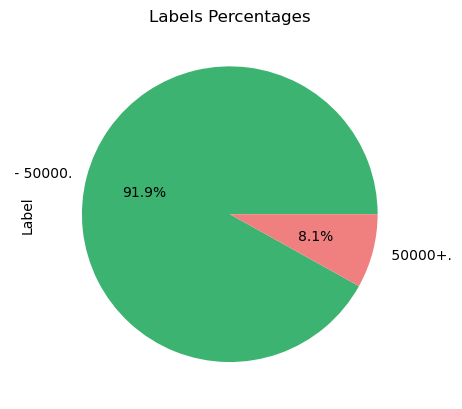

In [38]:
y = full_dataset['Label']
y.name = "Label"
y.value_counts().plot.pie(autopct='%1.1f%%', title = "Labels Percentages", colors = ['mediumseagreen', 'lightcoral'])

In [40]:
y = y.apply(lambda x : 0 if x == ' - 50000.' else 1)

In [42]:
continuous_variables.append('alternative_income_sources')
continuous_variables = list(set(continuous_variables))   # so that I will not append many time the 'alternative_income_sources variable
print(len(encoded_variables))
new_cols = ['continent of birth father', 'continent of birth mother', 'continent of birth self', 'employment_status_manual']
full_encoded_variables = encoded_variables + new_cols
full_encoded_variables = [col for col in full_encoded_variables if col not in ['country of birth father', 'country of birth mother', 'country of birth self']]
print(len(continuous_variables),len(full_encoded_variables))

33
8 34


In [43]:
# One Hot Encode Categorical Variables
all_encoded_data = pd.DataFrame()
for col in full_encoded_variables:
    encoded_data = encode_categorical_variable(input_df=full_dataset.reset_index(), col_name = col, id_col = 'user_id')
    all_encoded_data = join_to_df(encoded_data, all_encoded_data)

all_encoded_data 

,class of worker_Federal government,class of worker_Local government,class of worker_Never worked,class of worker_Not in universe,class of worker_Private,class of worker_Self-employed-incorporated,class of worker_Self-employed-not incorporated,class of worker_State government,class of worker_Without pay,detailed industry recode_0,...,continent of birth self_South America,employment_status_manual_(Uni) student,employment_status_manual_Armed Forces,employment_status_manual_Full-time,employment_status_manual_Hourly wage employee,employment_status_manual_Not in Label Force,employment_status_manual_Part-time,employment_status_manual_Remaining,employment_status_manual_Underaged,employment_status_manual_Unemployed
user_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152891,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
152892,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
152893,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [44]:
encoded_columns = list(all_encoded_data.columns)

In [45]:
# Build the dataset that is going to be used for the classification purpose
X = (full_dataset[continuous_variables].join(all_encoded_data))
valid_column_names = [col.replace('<', 'less than ') for col in X.columns ]
X.columns = valid_column_names
print(X.shape, y.shape)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(152896, 406) (152896,)
(107027, 406) (107027,) (45869, 406) (45869,)


In [46]:
for col in X.columns:
    if '<' in col:
        print(col)

In [47]:
# Random Forest
print(" --------------------- RF --------------------")
classifiers_outputs_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp_temp = {}
rf = CustomClassifier("RF")
rf.set_train_and_test_data(X_train, X_val, y_train, y_val)
rf.fit_model()
rf.estimate_accuracy()
rf.estimate_precision()
rf.estimate_f1_score()
rf.estimate_training_accuracy()

# Logistic Regression
print(" --------------------- LR --------------------")
lr = CustomClassifier("LR")
lr.set_train_and_test_data(X_train, X_val, y_train, y_val)
lr.fit_model()

lr.estimate_accuracy()
lr.estimate_precision()
lr.estimate_f1_score()
lr.estimate_training_accuracy()

# XGBoost
print(" --------------------- XGB --------------------")
xgb = CustomClassifier("XGBoost")
xgb.set_train_and_test_data(X_train, X_val, y_train, y_val)
xgb.fit_model()
xgb.estimate_accuracy()
xgb.estimate_precision()
xgb.estimate_f1_score()
xgb.estimate_training_accuracy()

 --------------------- RF --------------------
RF
Accuracy of RF classifier on test set: 0.9400
Precision of RF classifier on test set: 0.7354
F1-score (unweighted) of RF classifier on test set: 0.7455
F1-score (weigthed) of RF classifier on test set: 0.9319
Accuracy of RF classifier on training set: 0.9995
 --------------------- LR --------------------
LR


/Users/kleomeniskogias/opt/anaconda3/envs/dataiku_kernel/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of LR classifier on test set: 0.9278
Precision of LR classifier on test set: 0.7360
F1-score (unweighted) of LR classifier on test set: 0.6187
F1-score (weigthed) of LR classifier on test set: 0.9063
Accuracy of LR classifier on training set: 0.9285
 --------------------- XGB --------------------
XGBoost


/Users/kleomeniskogias/opt/anaconda3/envs/dataiku_kernel/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kleomeniskogias/opt/anaconda3/envs/dataiku_kernel/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:26:42] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGBoost classifier on test set: 0.9450
Precision of XGBoost classifier on test set: 0.7535
F1-score (unweighted) of XGBoost classifier on test set: 0.7776
F1-score (weigthed) of XGBoost classifier on test set: 0.9393
Accuracy of XGBoost classifier on training set: 0.9539


0.9539

In [76]:
# save_model_performance_in_dataframe(version = 'Basic Implementation', running_date=datetime(2022, 12, 28, 20, 55).strftime("%d/%m/%Y, %H:%M") , save_flag=1)
classifiers_output = save_model_performance_in_dataframe(version = 'New Features (Version 2)', save_flag=1)

/var/folders/k7/gq84mygx18v6xxlmhq1dbfzw0000gp/T/ipykernel_76130/311502982.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  classifiers_outputs = classifiers_outputs.append(classifiers_outputs_temp)


In [77]:
classifiers_output

,Model,Accuracy,Precision,F1_score unweighted,F1_score weighted,Training Accuracy,Version
Date,,,,,,,
"09/01/2023, 03:34",RF,0.94,0.738,0.746,0.932,1.0,New Features (Version 2)
"09/01/2023, 03:34",LR,0.928,0.737,0.617,0.906,0.928,New Features (Version 2)
"09/01/2023, 03:34",XGBoost,0.945,0.751,0.778,0.939,0.954,New Features (Version 2)


# Statistical Significance of Classification Output

H0: XGBoost and Random Forest have the same accuracy performance <br>
H1: XGBoost performs better than Random Forest

In [50]:
# Check for statistical significance
# Two proportion z-test

p1  = xgb.accuracy
p2 = rf.accuracy
n = X_val.shape[0]
x1 = round(p1 * n)
x2 = round(p2 * n)
p = (x1+x2)/(2*n)
# print(p1, p2, n, x1, x2, p)
Z = (p1 - p2)/(math.sqrt((2*p*(1-p)/n)))
Z = abs(Z)
print(f"Z = {round(Z, 4)}")

print(f"With confidence of {round(st.norm.cdf(Z)*100, 1)} % XGBoost performs better than Random Forest")

Z = 3.2527
With confidence of 99.9 % XGBoost performs better than Random Forest


# Feature Importance

In [51]:
feature_importance_table = xgb.estimate_feature_importance()
feature_importance_table['Cumulative Siginificance'] = feature_importance_table['Significance'].cumsum()
feature_importance_table['Question'] = feature_importance_table['Feature'].apply(lambda x : x.split('_')[0])
feature_importance_table[['Feature', 'Question', 'Significance', 'Cumulative Siginificance']].head(30)

,Feature,Question,Significance,Cumulative Siginificance
174,major occupation code_Other service,major occupation code,0.046615,0.046615
131,education_Prof school degree (MD DDS DVM LLB JD),education,0.043489,0.090104
7,weeks worked in year,weeks worked in year,0.038392,0.128497
220,tax filer stat_Nonfiler,tax filer stat,0.029036,0.157533
197,sex_Female,sex,0.027155,0.184688
169,major occupation code_Executive admin and mana...,major occupation code,0.025181,0.209869
177,major occupation code_Professional specialty,major occupation code,0.022137,0.232006
171,major occupation code_Handlers equip cleaners etc,major occupation code,0.019623,0.251629
4,alternative_income_sources,alternative,0.019573,0.271202
127,education_Doctorate degree(PhD EdD),education,0.019367,0.290569


In [55]:
feature_importance_table[feature_importance_table['Cumulative Siginificance'] <=0.5].groupby(['Question'])['Significance'].sum().reset_index().sort_values('Significance', ascending = False).head(10)#.to_clipboard()

,Question,Significance
9,major occupation code,0.149575
7,education,0.108079
5,detailed occupation recode,0.041205
12,weeks worked in year,0.038392
11,tax filer stat,0.038152
10,sex,0.027155
4,detailed industry recode,0.020905
0,alternative,0.019573
6,dividends from stocks,0.012772
1,capital gains,0.011366


In [56]:
feature_importance_table.groupby(['Question'])['Significance'].sum().reset_index().sort_values('Significance', ascending = False).head(10)#.to_clipboard()

,Question,Significance
23,major occupation code,0.159699
12,detailed occupation recode,0.153289
14,education,0.143727
11,detailed industry recode,0.112179
37,tax filer stat,0.047435
40,weeks worked in year,0.038392
5,class of worker,0.028855
35,sex,0.027155
36,state of previous residence,0.021006
1,alternative,0.019573


# Shapley values

/Users/kleomeniskogias/opt/anaconda3/envs/dataiku_kernel/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


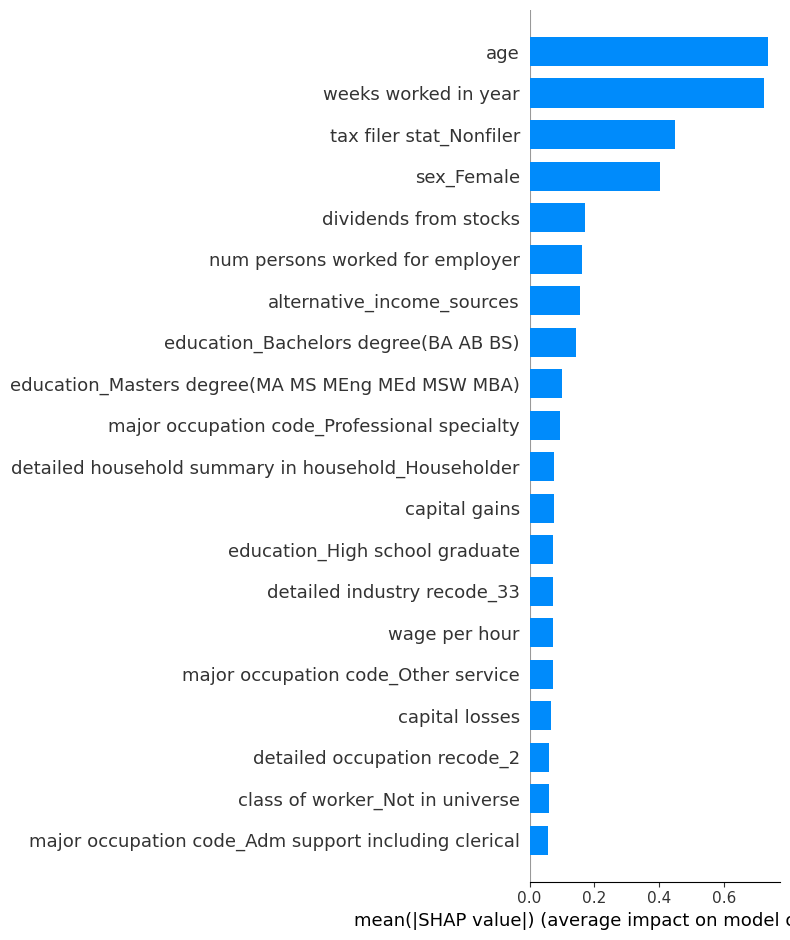

In [59]:
import shap
# Feature Importance–
explainer = shap.TreeExplainer(xgb.classifier)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X.values, plot_type="bar", class_names= list(y.reset_index()['Label'].drop_duplicates()), feature_names = X.columns)

In [63]:
len(shap_values[0])

406

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


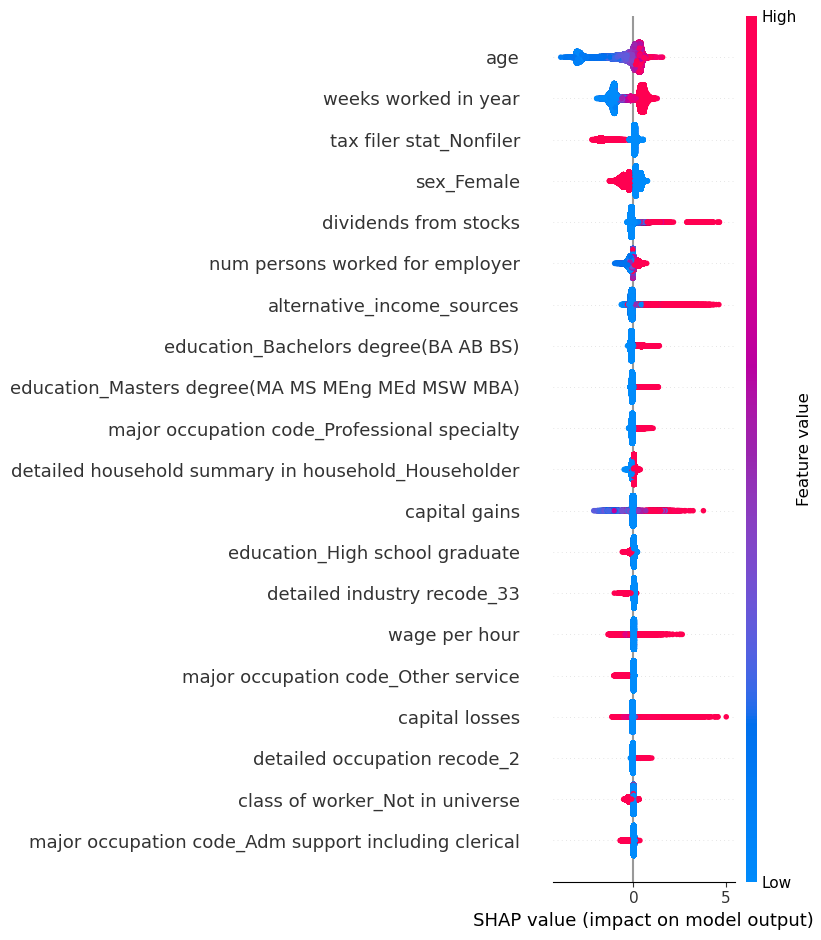

In [64]:
shap.summary_plot(shap_values, X.values, feature_names = X.columns)

# Model Optimisation

In [80]:
split_index = [-1 if x in xgb.X_train.index else 0 for x in X_train.append(X_val).index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)
print(len(split_index))


parameters = {
    'max_depth': [5, 10, 50, 100],
    'n_estimators': [50, 100, 200, 500, 1000],
    'min_samples_leaf' : [3, 5, 10, 50],
    'max_features' : ['auto', 0.4 ],
    'learning_rate': [0.05, 0.1, 1]
}

random_search = RandomizedSearchCV(
    estimator=xgb.classifier,
    param_distributions =parameters,
    n_iter= 50,
    scoring = 'accuracy',
    n_jobs = 1,
    cv = pds,
    verbose=10,
    random_state=7
)

152896


/var/folders/k7/gq84mygx18v6xxlmhq1dbfzw0000gp/T/ipykernel_76130/1413080243.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  split_index = [-1 if x in xgb.X_train.index else 0 for x in X_train.append(X_val).index]


In [ ]:
%%time # (6 hours)
random_search.fit(X_train.append(X_val), y_train.append(y_val))

In [82]:
print(random_search.best_params_)
print(random_search.best_score_)

{'n_estimators': 500, 'min_samples_leaf': 10, 'max_features': 0.4, 'max_depth': 5, 'learning_rate': 0.1}
0.945344350214742


# Prediction on Test-set

In [ ]:
# Formatting functions

# Create full dataset
def data_formatting(input_data, columns_type):
    X_data = input_data.loc[:, 0:40]
    X_data.columns = list(columns_type.keys())

    y = input_data.loc[:, 41]
    print(X_data.shape, y.shape)

    y.name = 'Label'
    full_dataset = X_data.join(y)

    # Strip values of categorical columns
    continuous_variables = []
    encoded_variables = []
    for key, value in columns_type.items():
        if value == 'continuous':
            continuous_variables.append(key)
        else:
            encoded_variables.append(key)


    for col in encoded_variables:
        if col in ['detailed industry recode', 'detailed occupation recode', 'own business or self employed', 'veterans benefits', 'year']:
            full_dataset[col] = full_dataset[col].astype(str)
        full_dataset[col] = full_dataset[col].apply(lambda x : x.strip())

    # Map countries to continents
    for col in country_columns:
        new_col_name = col.replace('country', 'continent')
        full_dataset[new_col_name] = full_dataset[col].apply(lambda x : countries_continents_dict[x])

    print(full_dataset[['continent of birth father', 'continent of birth mother', 'continent of birth self']].head())

    # Create new columns
    capital_fields = full_dataset[['capital gains', 'capital losses', 'dividends from stocks']].join(y)
    full_dataset['alternative_income_sources'] = full_dataset['capital gains'] + full_dataset['dividends from stocks'] - full_dataset['capital losses']
    full_dataset['unemployment_flag'] = full_dataset['reason for unemployment'].apply(lambda x : 0 if x == 'Not in universe' else 1)
    full_dataset['universe_descritpion'] = full_dataset.apply(lambda row : universe_breakdown(row['age'], row['full or part time employment stat'], row['major occupation code']), axis = 1)
    full_dataset['employment_status_manual'] = (full_dataset.apply(lambda row : create_manual_employment_status(
    row['unemployment_flag'], row['universe_descritpion'], row['own business or self employed'], row['wage per hour'], row['enroll in edu inst last wk'], row['veterans benefits'], row['full or part time employment stat']), axis = 1))

    return full_dataset

def classification_formatting(full_dataset, continuous_variables, full_encoded_variables):
    # Distribution of label
    y = full_dataset['Label']
    y.name = "Label"
    print(y.value_counts())
    y.value_counts().plot.pie(autopct='%1.1f%%', title = "Labels Percentages")
    # Binary label for classification
    y = y.apply(lambda x : 0 if x == ' - 50000.' else 1)
    # Use same continuous and encoded variables with training set
    print(len(continuous_variables),len(full_encoded_variables))
    # One Hot Encode Categorical Variables
    all_encoded_data = pd.DataFrame()
    for col in full_encoded_variables:
        encoded_data = encode_categorical_variable(input_df=full_dataset.reset_index(), col_name = col, id_col = 'user_id')
        all_encoded_data = join_to_df(encoded_data, all_encoded_data)

    X = (full_dataset[continuous_variables].join(all_encoded_data))
    valid_column_names = [col.replace('<', 'less than ') for col in X.columns ]
    X.columns = valid_column_names
    print(X.shape, y.shape)

    return X, y

In [117]:
opt_dict = random_search.best_params_
print(random_search.best_params_)
print(random_search.best_score_)


{'n_estimators': 500, 'min_samples_leaf': 10, 'max_features': 0.4, 'max_depth': 5, 'learning_rate': 0.1}
0.945344350214742


In [104]:
# Aplly the same formatting to the test set
full_test_dataset = data_formatting(test_data, columns_type)
print(full_test_dataset.shape)


(78864, 40) (78864,)
        continent of birth father continent of birth mother  \
user_id                                                       
152896              North America             North America   
152897              North America             North America   
152898              North America             North America   
152899              North America             North America   
152900              North America             North America   

        continent of birth self  
user_id                          
152896            North America  
152897            North America  
152898            North America  
152899            North America  
152900            North America  
(78864, 48)


 - 50000.    72678
 50000+.      6186
Name: Label, dtype: int64
8 34
(78864, 405) (78864,)


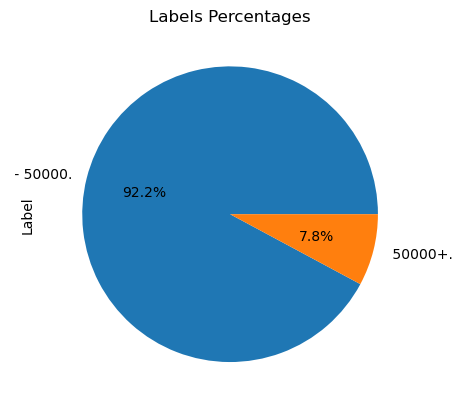

In [108]:
X_test, y_test = classification_formatting(full_test_dataset, continuous_variables, full_encoded_variables)

In [115]:
# Add columns that we were missing from OHE, because test set has less submissions
for col in list(set(list(X_train.columns)).difference(set(list(X_test.columns)))):
    X_test[col] = 0

print(X_test.shape)
# Align column order for train and test set
X_test.columns  = list(X_train.columns)


(78864, 406)


In [121]:
final_classifier = CustomClassifier("XGBoost")
final_classifier.set_train_and_test_data(X_train.append(X_val), X_test, y_train.append(y_val), y_test)
# final_classifier.set_train_and_test_data(X_train, X_val, y_train, y_val)
final_classifier.fit_model(n_estimators = opt_dict['n_estimators'], min_samples_leaf = opt_dict['min_samples_leaf'], max_features = opt_dict['max_features'], max_depth = opt_dict['max_depth'], learning_rate = opt_dict['learning_rate']) # with these parameters I get the same test output with a lighter model
print(final_classifier.classifier)
final_classifier.estimate_accuracy()
final_classifier.estimate_precision()
final_classifier.estimate_f1_score()
final_classifier.estimate_training_accuracy()
print(final_classifier.X_train.shape, final_classifier.y_train.shape, final_classifier.X_test.shape, final_classifier.y_test.shape)

/var/folders/k7/gq84mygx18v6xxlmhq1dbfzw0000gp/T/ipykernel_76130/2724514082.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_classifier.set_train_and_test_data(X_train.append(X_val), X_test, y_train.append(y_val), y_test)
/var/folders/k7/gq84mygx18v6xxlmhq1dbfzw0000gp/T/ipykernel_76130/2724514082.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_classifier.set_train_and_test_data(X_train.append(X_val), X_test, y_train.append(y_val), y_test)
/Users/kleomeniskogias/opt/anaconda3/envs/dataiku_kernel/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your

XGBoost
[14:36:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "max_features", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:36:23] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical